# 25.01.23   
### 공공자전거 수요 예측 실습: 회귀모델

# 작업준비
* 데이터 수집 : https://www.kaggle.com/competitions/bike-sharing-demand/data

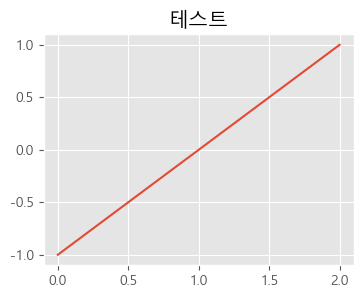

In [2]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# 한글폰트 설정
import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

pd.Series([-1,0,1]).plot(figsize=(4,3), title='테스트')
plt.show()

# 데이터 불러오기
* **`pd.read_csv(csv파일 경로, parse_dates=[datetime형식으로 불러올 컬럼])`**

* 속성 정보
    * `datetime` - 시간대별 데이터 제공. timestamp(날짜와 시간 결합) 형태
    * `season`  - 1 = spring, 2 = summer, 3 = fall, 4 = winter
    * `holiday` - 공휴일(주말이 아닌 빨간날). 1-yes, 2-no
    * `workingday` - 주말, 공휴일을 제외한 날 1-yes, 2-no
    * `weather`
        * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
        * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    * `temp` - 섭씨온도
    * `atemp` - 섭씨체감온도
    * `humidity` - 상대습도
    * `windspeed` - 풍속
    * `casual` - 비회원 대여량
    * `registered` - 회원 대여량
    * `count` - 총 대여량


In [3]:
# datetime 컬럼은 datetime 형식으로 읽어오도록 옵션 설정
# df = pd.read_csv('https://raw.githubusercontent.com/JayoungKim-ai/ML_dataset/main/BikeSharingDemand.csv', parse_dates=['datetime'])
df = pd.read_csv('data/bike_sharing_demand.csv', parse_dates=['datetime'])
display(df.head(3))
display(df.tail(3))

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [4]:
# 데이터 정보
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


# 파생컬럼 추가

In [5]:
# 연, 월, 일, 시, 요일
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek # 월요일:0, 일요일:6
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


# 데이터 탐색(EDA)
* 데이터의 품질 확인(값의 분포, 결측치, 이상치 등)
* 독립변수와 종속변수간의 관계를 중점적으로 탐색

## datetime

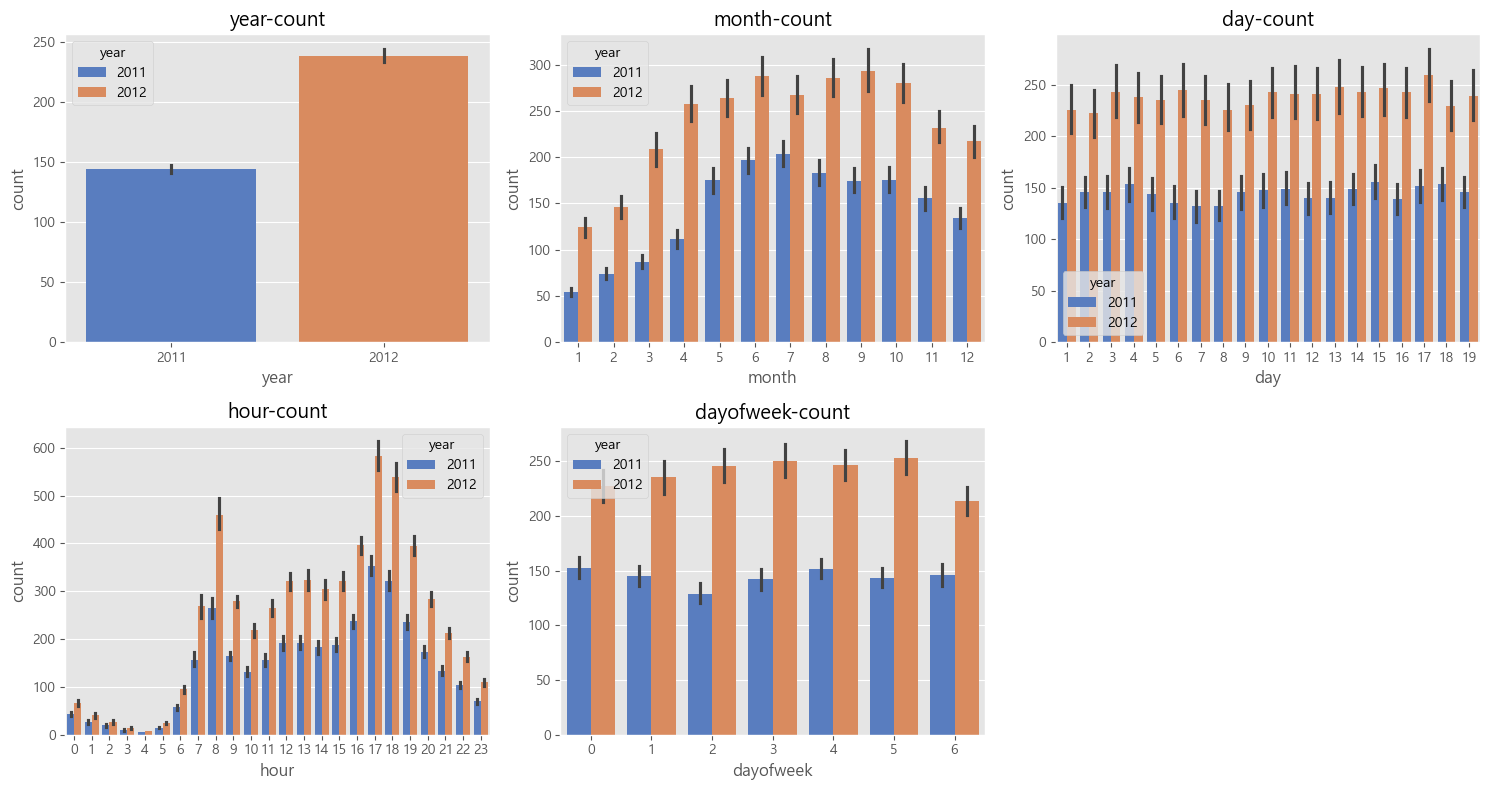

In [6]:
plt.figure(figsize=(15,8))

features = ['year','month','day','hour','dayofweek']

for i, feature in enumerate(features):
    plt.subplot(2,3,i+1)
    sns.barplot(data=df, x=feature, y='count', estimator='mean', hue='year', palette='muted')
    plt.title(feature+'-count')

plt.tight_layout()

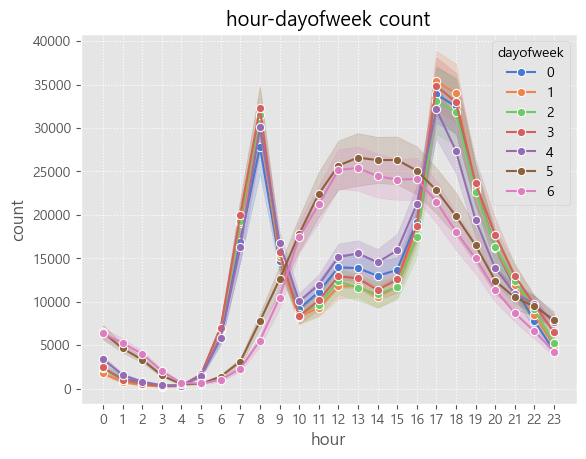

In [7]:
# 시간대 - 요일 별 대여량
sns.lineplot(data=df, x='hour', y='count', marker='o', hue='dayofweek', estimator='sum', palette='muted')
plt.title('hour-dayofweek count')
plt.xticks(range(0,24))
plt.grid(ls=':')
plt.show()

## season
* 1 - 1,2,3월
* 2 - 4,5,6월
* 3 - 7,8,9월
* 4 - 10,11,12월

In [8]:
df[['month', 'season']].drop_duplicates()

,month,season
0,1,1
431,2,1
877,3,1
1323,4,2
1778,5,2
2234,6,2
2690,7,3
3146,8,3
3602,9,3
4055,10,4


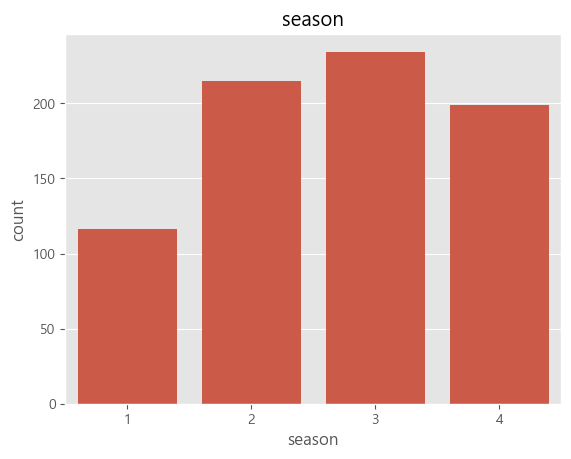

In [9]:
sns.barplot(data=df, x='season', y='count', errorbar=None)
plt.title('season')
plt.show()

<Axes: xlabel='month', ylabel='mean temp'>

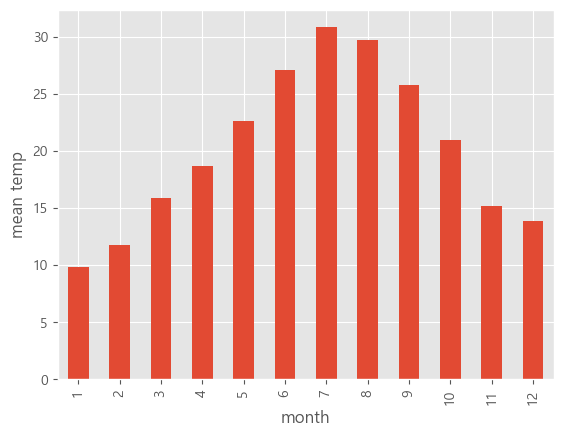

In [10]:
# 월별 평균 기온
df.groupby('month')['temp'].mean().plot.bar(ylabel='mean temp')

<Axes: xlabel='month', ylabel='mean temp'>

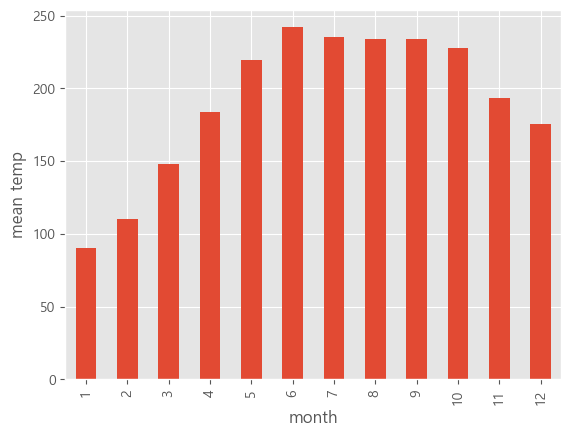

In [11]:
# 월별 평균 대여량
df.groupby('month')['count'].mean().plot.bar(ylabel='mean temp')

## holiday
* 공휴일(평일 중 빨간날)
* 토,일은 원래 쉬는 날로, holiday로 간주하지 않음
* 공휴일과 비공휴일의 날짜수의 차이가 있으므로, 평균 대여량으로 비교한다.

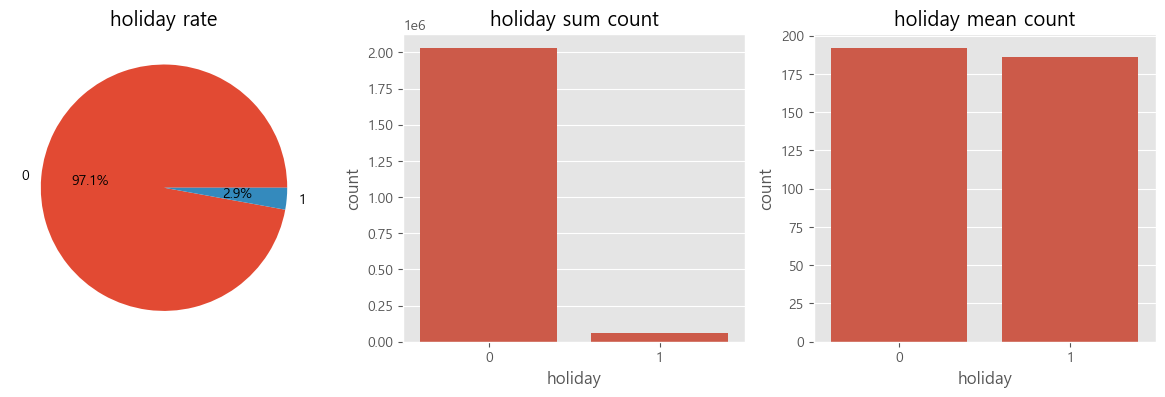

In [12]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.pie(df['holiday'].value_counts(), autopct='%.1f%%', labels=['0','1'])
plt.title('holiday rate')

plt.subplot(132)
sns.barplot(data=df, x='holiday', y='count', errorbar=None, estimator='sum')
plt.title('holiday sum count')

plt.subplot(133)
sns.barplot(data=df, x='holiday', y='count', errorbar=None, estimator='mean')
plt.title('holiday mean count')

plt.show()

## workingday
* 평일 중 holiday를 제외한 날이 workingday
* workingday와 workingday의 날짜수의 차이가 있으므로, 평균 대여량으로 비교한다.

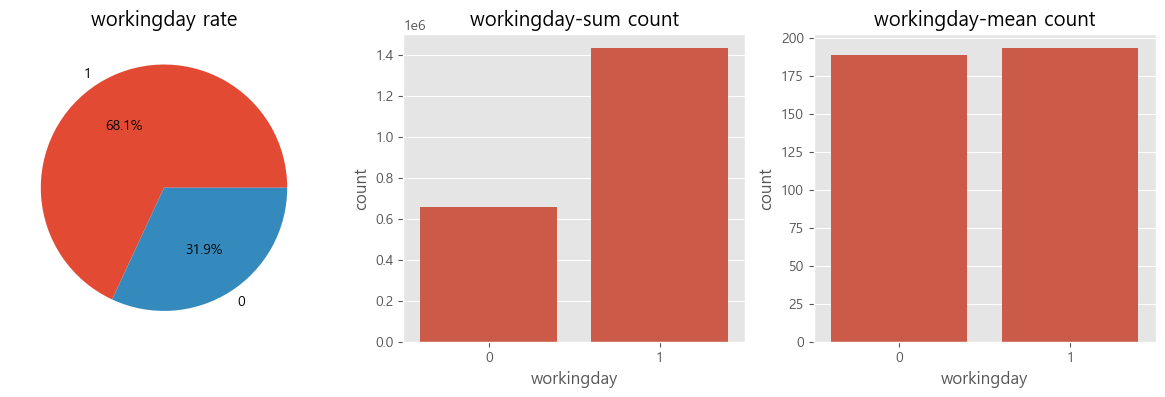

In [13]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.pie(df['workingday'].value_counts(), autopct='%.1f%%', labels=['1','0'])
plt.title('workingday rate')

plt.subplot(132)
sns.barplot(data=df, x='workingday', y='count', errorbar=None, estimator='sum')
plt.title('workingday-sum count')

plt.subplot(133)
sns.barplot(data=df, x='workingday', y='count', errorbar=None, estimator='mean')
plt.title('workingday-mean count')

plt.show()

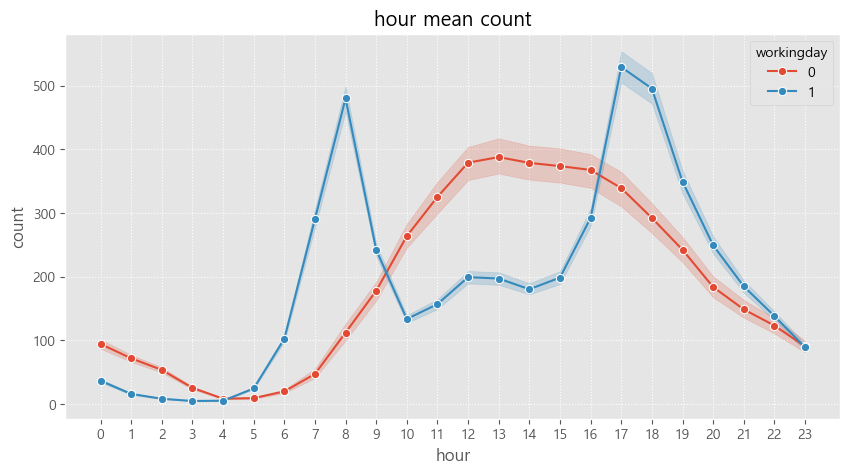

In [14]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='hour', y='count', marker='o', hue='workingday')
plt.title('hour mean count')
plt.xticks(range(0,24))
plt.grid(ls=':')
plt.show()

## weather
* 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mis
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clou
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow +    Fog
* weather가 4인 날은 단 하루밖에 없었음

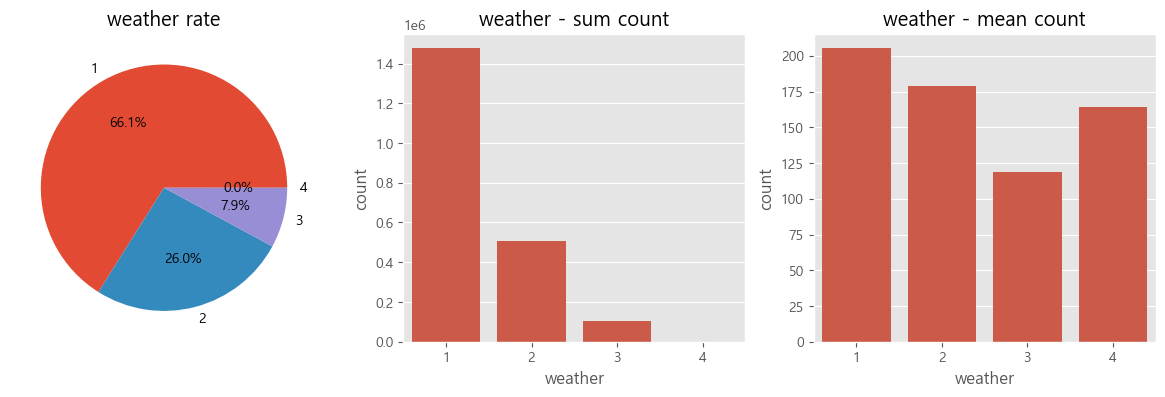

In [15]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.pie(df['weather'].value_counts(), autopct='%.1f%%', labels=[1,2,3,4])
plt.title('weather rate')

plt.subplot(132)
sns.barplot(data=df, x='weather', y='count', errorbar=None, estimator='sum')
plt.title('weather - sum count')

plt.subplot(133)
sns.barplot(data=df, x='weather', y='count', errorbar=None, estimator='mean')
plt.title('weather - mean count')

plt.show()

In [16]:
df['weather'].value_counts()

weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64

## temp

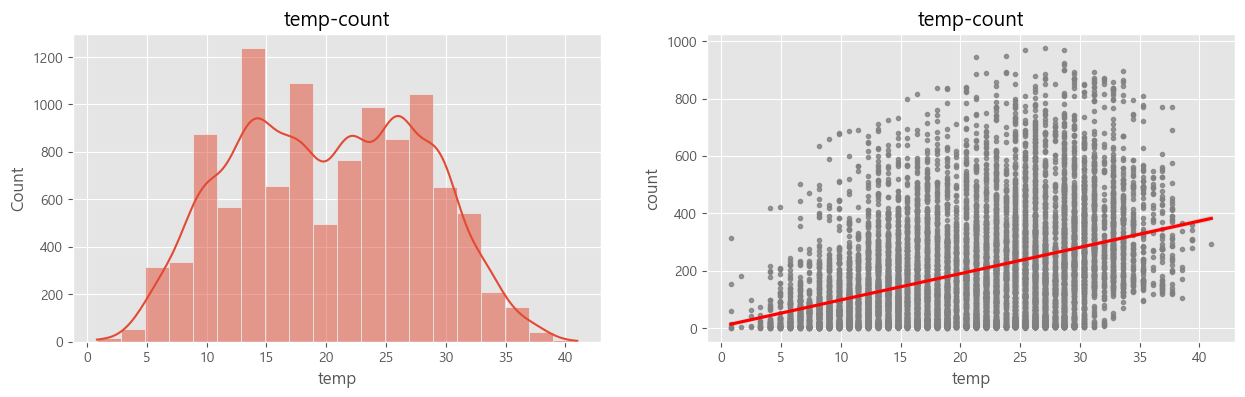

In [17]:
plt.figure(figsize=(15,4))

plt.subplot(121)
sns.histplot(df['temp'], bins=20, kde=True)
plt.title('temp-count')

plt.subplot(122)
sns.regplot(data=df, x='temp', y='count', color='gray', line_kws={'color':'red'}, marker='.')
plt.title('temp-count')

plt.show()

## atemp

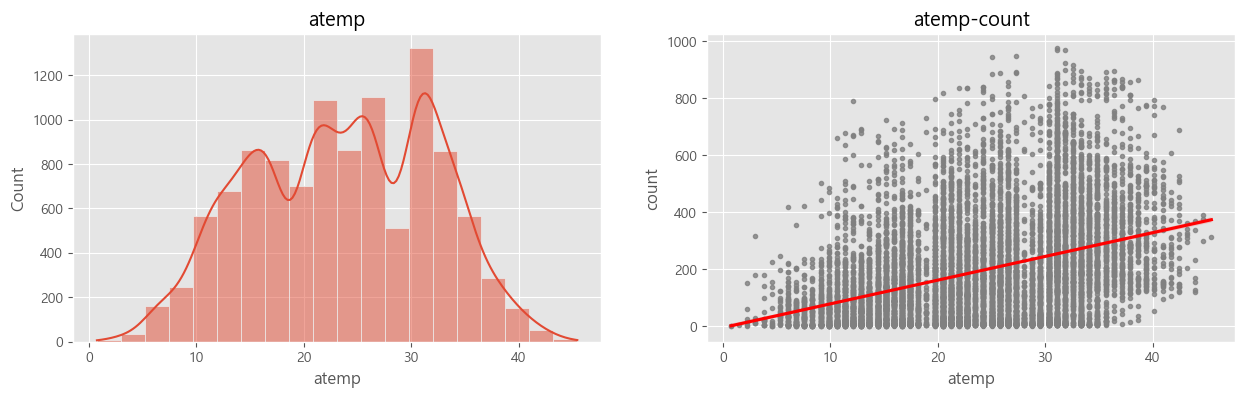

In [18]:
plt.figure(figsize=(15,4))

plt.subplot(121)
sns.histplot(df['atemp'], bins=20, kde=True)
plt.title('atemp')


plt.subplot(122)
sns.regplot(data=df, x='atemp', y='count', color='gray', line_kws={'color':'red'}, marker='.')
plt.title('atemp-count')

plt.show()

## humidity


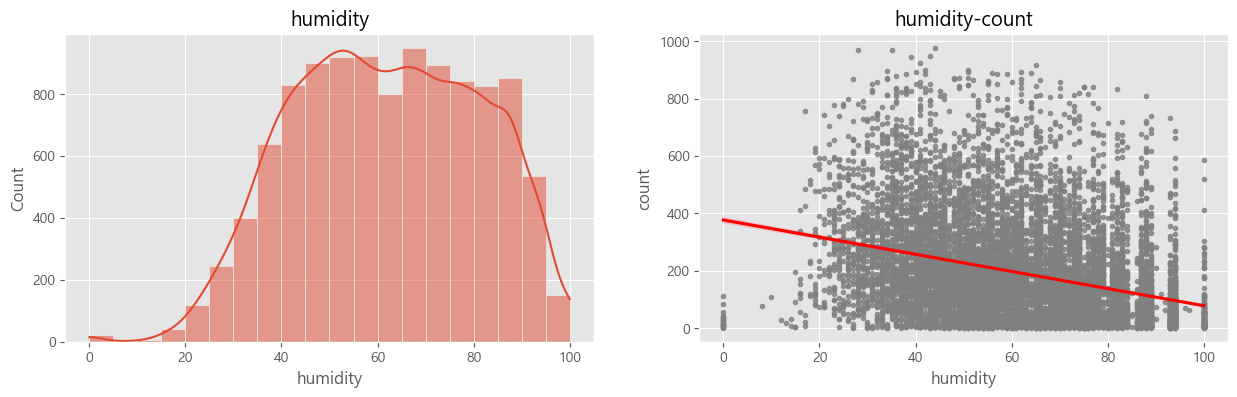

In [19]:
plt.figure(figsize=(15,4))

plt.subplot(121)
sns.histplot(df['humidity'], bins=20, kde=True)
plt.title('humidity')

plt.subplot(122)
sns.regplot(data=df, x='humidity', y='count', color='gray', line_kws={'color':'red'}, marker='.')
plt.title('humidity-count')

plt.show()

## windspeed
* value가 0인 데이터가 10% 이상
    * 풍속이 0인 경우는 없다고 보고, 해당 값은 결측이라고 본다.
* windspeed의 값이 0인 데이터들은 결측치가 0으로 채워진 상태인 것으로 파악
* feature engineering 필요

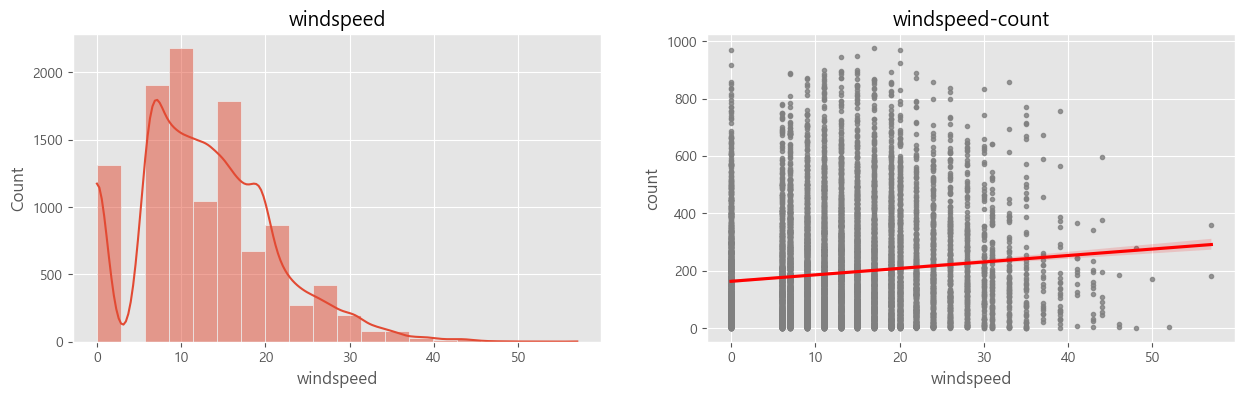

In [20]:
plt.figure(figsize=(15,4))

plt.subplot(121)
sns.histplot(df['windspeed'], bins=20, kde=True)
plt.title('windspeed')

plt.subplot(122)
sns.regplot(data=df, x='windspeed', y='count', color='gray', line_kws={'color':'red'}, marker='.')
plt.title('windspeed-count')

plt.show()

## casual, registered, count

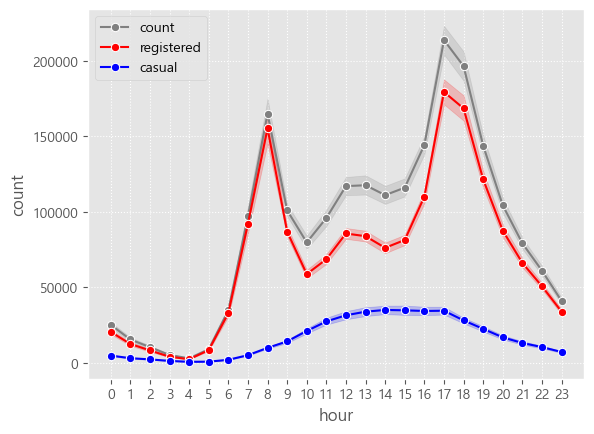

In [21]:
sns.lineplot(data=df, x='hour', y='count', color='gray', marker='o', estimator='sum', label='count')
sns.lineplot(data=df, x='hour', y='registered', color='red', marker='o', estimator='sum', label='registered')
sns.lineplot(data=df, x='hour', y='casual', color='blue', marker='o', estimator='sum', label='casual')
plt.legend()
plt.xticks(range(0,24))
plt.grid(ls=':')
plt.show()

## 상관계수
* 피어슨 상관계수
    * 두 변수 간의 선형 관계의 강도와 방향을 측정.
    * 파이썬에서 corr()함수를 이용하여 구할 수 있음.
    * +1과 -1 사이의 값을 가진다.
        * +1 : 완벽한 양의 선형 상관 관계
        * -1 : 완벽한 음의 상관관계
        * 0 : 선형 상관 관계 없음,
    
* 다중공선성
    * 독립변수 간 강한 상관관계가 있는 경우
    * 둘중 하나의 변수만 사용

In [109]:
df[df.keys()].corr()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
datetime,1.000000,0.480021,0.010988,-0.003658,-0.005048,0.180986,0.181823,0.032856,-0.086888,0.172728,0.314879,0.310187,0.866570,0.494087,0.028563,-0.005663,-0.004676
season,0.480021,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,-0.004797,0.971524,0.001729,-0.006546,-0.010553
holiday,0.010988,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,0.012021,0.001731,-0.015877,-0.000354,-0.191832
workingday,-0.003658,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,-0.002482,-0.003394,0.009829,0.002780,-0.704267
weather,-0.005048,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.012548,0.012144,-0.007890,-0.022740,-0.047692
temp,0.180986,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.061226,0.257589,0.015551,0.145430,-0.038466
atemp,0.181823,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.058540,0.264173,0.011866,0.140343,-0.040235
humidity,0.032856,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,-0.078606,0.204537,-0.011335,-0.278011,-0.026507
windspeed,-0.086888,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,-0.015221,-0.150192,0.036157,0.146631,-0.024804
casual,0.172728,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.145241,0.092722,0.014109,0.302045,0.246959


<Axes: >

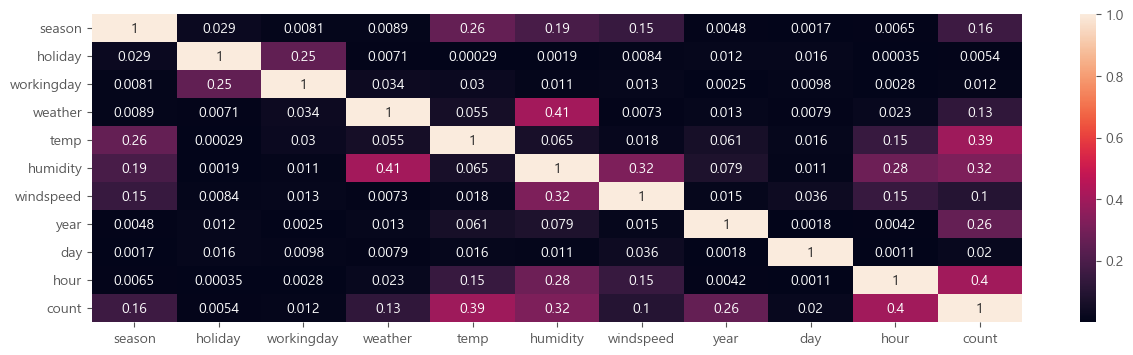

In [114]:
# corr = df[df.keys()].corr()
corr = df[['season','holiday','workingday','weather','temp','humidity','windspeed','year','day','hour','count']].corr()
# corr = df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
plt.figure(figsize=(15,4))
sns.heatmap(abs(corr), annot=True)

# LinearRegression

<Axes: >

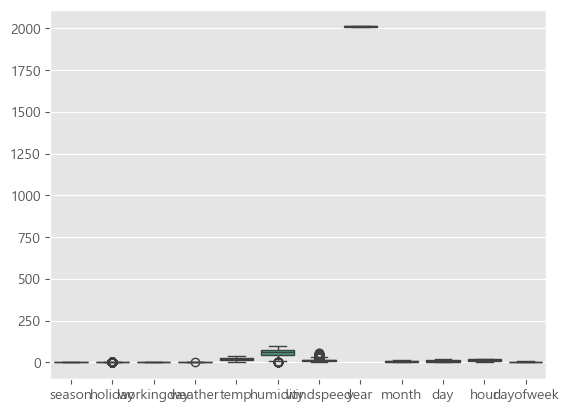

In [69]:
# 변수선택
X = df[['season', 'holiday', 'workingday', 'weather', 'temp',\
        'humidity', 'windspeed','year', 'month', 'day', 'hour', 'dayofweek']]
y = df['count']

sns.boxplot(X)

In [64]:

# 훈련세트/테스트세트 분할

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

# sns.scatterplot(x=X_train['temp'], y=y_train, label='train')
# sns.scatterplot(x=X_test['temp'], y=y_test, label='test')


((8164, 12), (2722, 12), (8164,), (2722,))

In [65]:
# 모델 생성

from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [66]:
# 테스트데이터로 예측
pred = model.predict(X_test)
# 모델 성능 평가

from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, pred)
rmse = root_mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f'MSE : {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE : {mae:.2f}')
print(f'R2 : {r2:.2f}')

MSE : 20101.93
RMSE: 141.78
MAE : 105.57
R2 : 0.39


## 원핫인코딩

In [115]:
# 변수선택
# X = df[['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed','year', 'month', 'day', 'hour', 'dayofweek']]
X = df[['temp','humidity','windspeed','season','holiday','workingday','weather','year','day','hour']]
y = df['count']

# 범주형변수 원핫인코딩
X_ohe = pd.get_dummies(X, columns=['season','holiday','workingday','weather','year','day','hour'])
X_ohe.head()


,temp,humidity,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,81,0.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,9.02,80,0.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
2,9.02,80,0.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3,9.84,75,0.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,9.84,75,0.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


(8164, 60) (2722, 60) (8164,) (2722,)
MSE : 10305.63
RMSE: 101.52
MAE : 75.02
R2 : 0.69


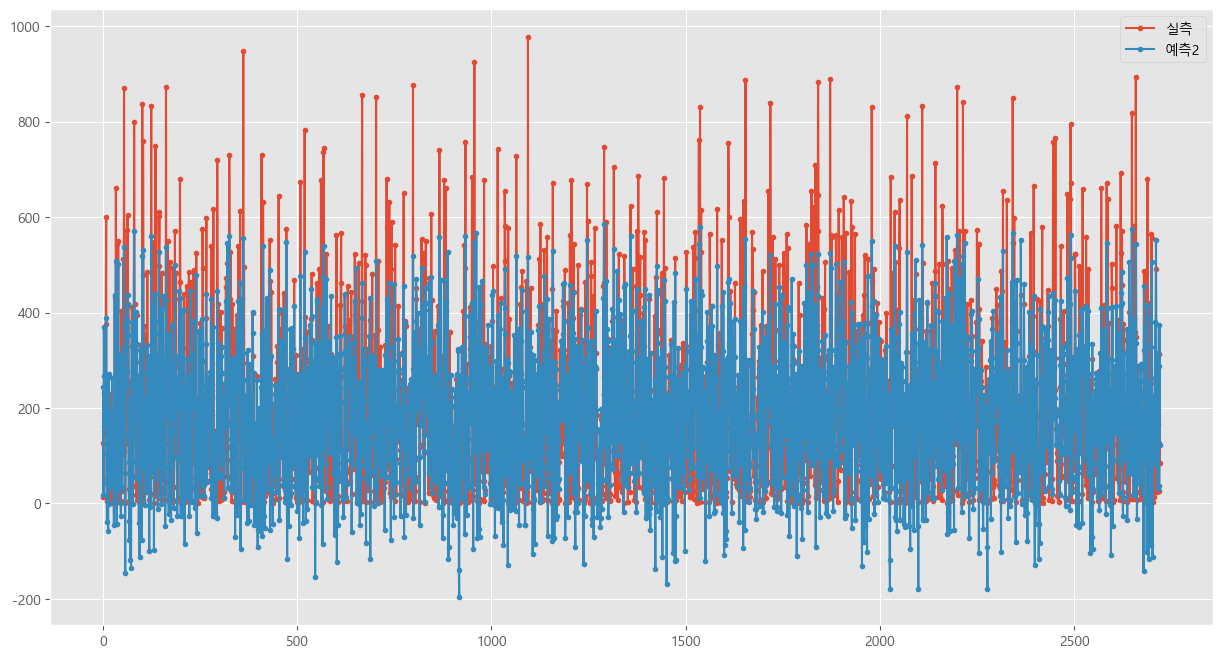

In [164]:
# 훈련세트/테스트세트 분할할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 모델 생성
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# 테스트데이터로 예측
pred = model.predict(X_test)

# 모델 성능 평가
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, pred)
rmse = root_mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f'MSE : {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE : {mae:.2f}')
print(f'R2 : {r2:.2f}')

plt.figure(figsize=(15,8))
plt.plot(np.array(y_test), marker='.', label='실측')
plt.plot(pred, marker='.', label='예측2')
plt.legend()

pass

## 종속변수 로그변환

,temp,humidity,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,81,0.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,9.02,80,0.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
2,9.02,80,0.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3,9.84,75,0.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,9.84,75,0.0,True,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


<Axes: >

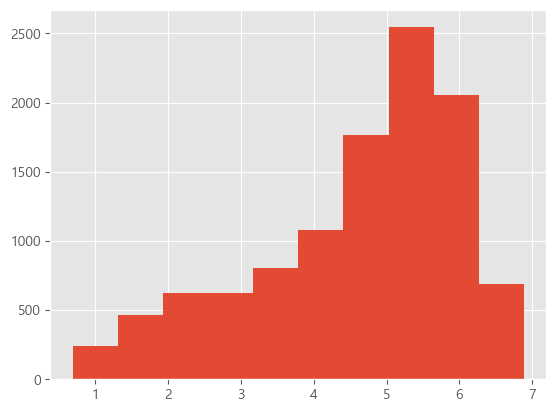

In [ ]:
# 변수선택
X = df[['temp','humidity','windspeed','season','holiday','workingday','weather','year','day','hour']]
y = df['count']

# 범주형변수 원핫인코딩
X_ohe = pd.get_dummies(X, columns=['season','holiday','workingday','weather','year','day','hour'])
display(X_ohe.head())

# 종속변수 로그변환
y_log = np.log1p(y)

# y.hist() # 치우친 그래프
y_log.hist()

(8164, 60) (2722, 60) (8164,) (2722,)
MSE : 9340.81
RMSE: 96.65
MAE : 62.69
R2 : 0.72


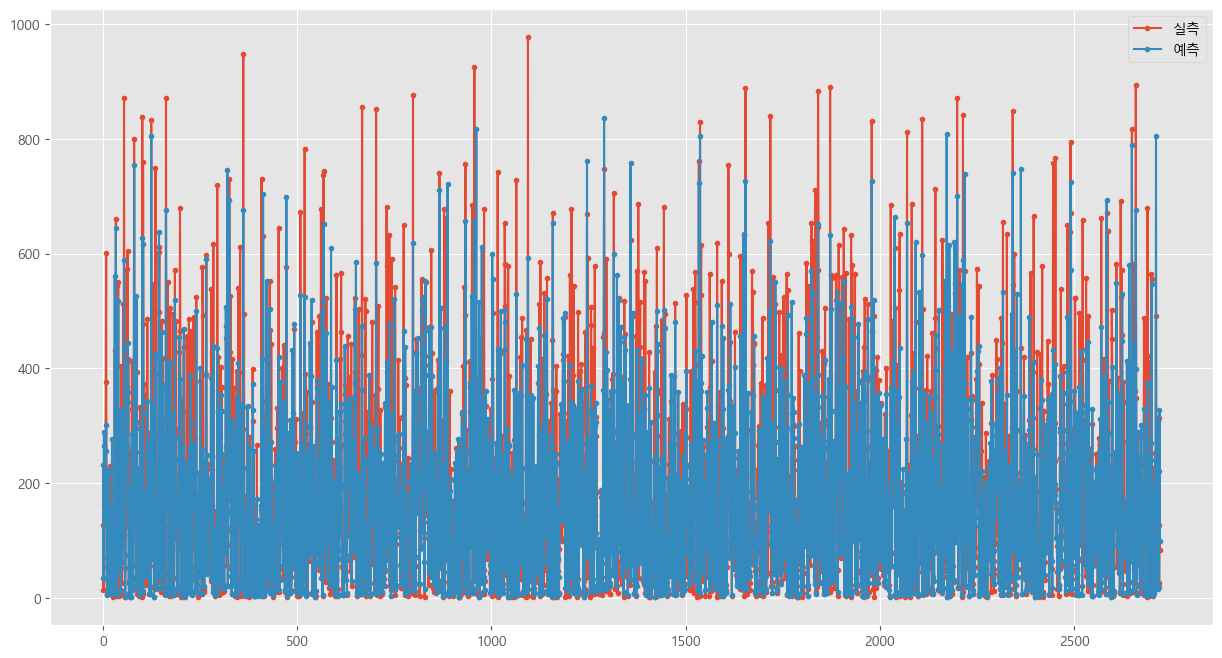

In [167]:
# 훈련세트/테스트세트 분할할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_log, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 모델 생성
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# 테스트데이터로 예측
pred = model.predict(X_test)

# 로그 역변환
# 성능 검사때는 역변환 필요없지만
# 실제 값을 예측해야할 때는 필요
y_test2 = y_test
pred = np.expm1(pred)
y_test = np.expm1(y_test)

# 모델 성능 평가
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, pred)
rmse = root_mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f'MSE : {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE : {mae:.2f}')
print(f'R2 : {r2:.2f}')

plt.figure(figsize=(15,8))
plt.plot(np.array(y_test), marker='.', label='실측')
plt.plot(pred, marker='.', label='예측')
plt.legend()

pass

In [148]:
display(X_test)

,temp,humidity,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
3133,33.62,59,0.0000,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
5786,4.10,54,6.0032,True,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
5224,9.84,48,12.9980,False,False,False,True,True,False,True,...,False,False,False,False,True,False,False,False,False,False
8953,29.52,62,12.9980,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
8054,25.42,53,16.9979,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,20.50,29,27.9993,True,False,False,False,True,False,True,...,False,True,False,False,False,False,False,False,False,False
5605,16.40,37,19.9995,True,False,False,False,True,False,True,...,False,False,True,False,False,False,False,False,False,False
2935,27.06,74,8.9981,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3058,27.06,65,11.0014,False,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


## cross validation

In [158]:
model1 = LinearRegression()

from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
print(cross_val_score(model1, X, y, scoring='r2', cv=kf).mean())
print(cross_val_score(model1, X_ohe, y, scoring='r2', cv=kf).mean())

0.384819376736279
0.6853897702687417


# 다른 모델과 비교

In [159]:
from sklearn.neighbors import KNeighborsRegressor
model1 = KNeighborsRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
print(cross_val_score(model1, X, y, scoring='r2', cv=kf).mean())
print(cross_val_score(model1, X_ohe, y, scoring='r2', cv=kf).mean())

0.5289892548275092
0.27168184684552826


In [162]:
from sklearn.tree import DecisionTreeRegressor
# model1 = DecisionTreeRegressor(max_depth=5)
model1 = DecisionTreeRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
print(cross_val_score(model1, X, y, scoring='r2', cv=kf).mean())
print(cross_val_score(model1, X_ohe, y, scoring='r2', cv=kf).mean())

0.8802422584645244
0.8258272456458216


In [163]:
from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
print(cross_val_score(model1, X, y, scoring='r2', cv=kf).mean())
print(cross_val_score(model1, X_ohe, y, scoring='r2', cv=kf).mean())

0.9390667677995467
0.9160301624694528
